test1
****************************
test
****************************


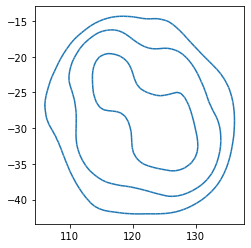

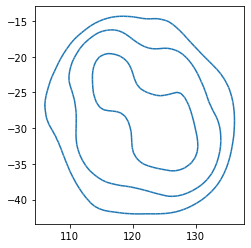

In [44]:
########################################################################################
# This code has functionality for converting gxt files with GPS satellite contour data #
# to shape file/ Kml file format with gps path connecting gps points                   #
#######################################################################################

# import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import glob

# listing all gxt
gxt_list = glob.glob('*gxt')

for gxt in gxt_list:
    fname = gxt[:-4]
    print(fname)
    # read gxt file
    raw = pd.read_table('test.gxt')
    # rename column name
    raw_ds = raw.rename(columns={'[FormatInfo]':'data'})
    # see locations of data records(breaking points)
    break_df = raw_ds[raw_ds['data'].str.contains("n_point")]
    # breaking point list
    br_points = list(break_df.index.values)
    #print(br_points, 'br points')
    # extract number of records from break df
    numdf = break_df.copy(deep=True)
    # split coloumn
    numdf['info'] = numdf.data.str.split('=')
    # extract number of data from info list column
    nums = list(numdf['info'].str[1])
    # convert to array to cast to int dtype
    nums = np.array(nums).astype(int)
    # converting back to list > number of records list
    records = nums.tolist()
    #print(records, 'records')
    # record starting point
    starting_point = [item+1 for item in br_points]
    #print(starting_point, ' starting point')
    #  record ending point
    ending_point = [i+j for i,j in zip(records, starting_point)]
    #print(ending_point, 'ending')
    # slicing raw df to 3 parts
    splitted_list = [raw_ds[i:j]for i, j in zip(starting_point, ending_point)]
    # empty list to collect df for lines gemetries from each sliced dataframes to a single data frame
    linedf_list = []
    # use a counter to name data frames if saving nedded
    for count,df in enumerate(splitted_list,1):
        #print(count,df.head(2))
        #filename = fname+'_'+str(count)
        #dframe.to_csv(filename+'.csv')
        exdf = df.copy(deep=True)
        exdf['drop1'] = exdf.data.str.split('=')
        # split the point lable and latlon into 2 columns
        exdf[['location','drop3']] = pd.DataFrame(exdf.drop1.tolist(), index= exdf.index)
        # create lat lon columns
        exdf['lon'] = exdf.drop3.str.slice(0,8)
        exdf['lat'] = exdf.drop3.str.slice(9,)
        # df to gdf
        point_df = gpd.GeoDataFrame(exdf, geometry=gpd.points_from_xy(x=exdf.lon, y=exdf.lat),
                                    crs = 'EPSG:4326')
        # drop redandant columns of geodata frame for points
        point_df = point_df.drop(['data', 'drop1', 'drop3', 'lon', 'lat'], axis = 1)
        # ploting
        #point_df.plot()
        # create list of geometry of point file
        geom_list = list(point_df.geometry)
        # data frame intiation for line gdf
        linedf = pd.DataFrame(columns=['id','geometry'])
        # empty list for gemetry
        line_geom = []
        # itterate over geometry lists
        for i in range(len(geom_list)-1):
            # elemant one
            g1 = geom_list[i]
            # second elemant
            g2 = geom_list[i+1]
            # line start end points
            start, end = [(g1.x, g1.y), (g2.x, g2.y)]
            # linestring geometry
            line = LineString([start, end])
            # append linelets to the line geometry list
            line_geom.append(line)
           
        # appding line geom list to df
        linedf['geometry'] = line_geom
        # adding an id to df
        linedf['id'] = [i for i in range(len(geom_list)-1)]
        #print(linedf.head())
        linedf_list.append(linedf)
    # concat  line df for each data frame slice to path df for single file output
    path_df = pd.concat(linedf_list)
    # path gdf
    path_gdf = gpd.GeoDataFrame(path_df, crs='EPSG:4326', geometry='geometry')
    path_gdf.plot()
    # kml driver from fiona 
    fiona.supported_drivers['KML'] = 'rw'
    # save as kml file/shape file
    #path_gdf.to_file(fname+'_gps_path.kml', driver='KML')
        
    print('****************************')
  